In [1]:
import cv2
import numpy as np
import os
import pandas as pd
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.preprocessing import image
import sklearn.metrics.pairwise as pairwise
cosine_similarity = pairwise.cosine_similarity
from matplotlib import pyplot as plt

In [2]:
import warnings

In [3]:
MODELS = ["vgg16", "resnet50", "inception", "mobilenet"]

In [4]:
def load_and_preprocess_image(img_path, target_size, preprocess_func):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_func(img_array)

def calculate_similarity(img_path1, img_path2, model_name):
    models = {
        MODELS[0]: (VGG16, (224, 224), vgg_preprocess),
        MODELS[1]: (ResNet50, (224, 224), resnet_preprocess),
        MODELS[2]: (InceptionV3, (299, 299), inception_preprocess),
        MODELS[3]: (MobileNetV2, (224, 224), mobilenet_preprocess)
    }

    if model_name not in models:
        raise ValueError(f"Unsupported model: {model_name}. Choose from {', '.join(models.keys())}")

    ModelClass, input_size, preprocess_func = models[model_name]

    #ignore warnings
    warnings.filterwarnings("ignore", category=UserWarning)
        
    # Load pre-trained model
    model = ModelClass(weights='imagenet', include_top=False, pooling='avg')

    # Load and preprocess images
    img1 = load_and_preprocess_image(img_path1, input_size, preprocess_func)
    img2 = load_and_preprocess_image(img_path2, input_size, preprocess_func)
    
    # Extract features
    features1 = model.predict(img1, verbose=0)
    features2 = model.predict(img2,verbose=0)
    
    # Calculate cosine similarity
    similarity = cosine_similarity(features1, features2)
    
    return similarity[0][0] * 100  # Convert to percentage

In [5]:
def display_images_with_similarity_scores(img_path1, img_path2):
    # Calculate similarity
    similarity_score_vgg = calculate_similarity(img_path1, img_path2, 'vgg16')
    similarity_score_inception = calculate_similarity(img_path1, img_path2, 'inception')

    similarity_score = (similarity_score_vgg + similarity_score_inception)/2
    
    
    # Load images using cv2
    img1 = cv2.imread(img_path1)
    img2 = cv2.imread(img_path2)
    
    # Convert BGR to RGB (cv2 loads in BGR, but matplotlib expects RGB)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display images
    ax1.imshow(img1)
    ax1.set_title('Image 1')
    ax1.axis('off')
    
    ax2.imshow(img2)
    ax2.set_title('Image 2')
    ax2.axis('off')
    
    # Add overall title with similarity score
    plt.suptitle(f'Similarity Score: {similarity_score:.2f}%', fontsize=16)
    
    plt.tight_layout()
    plt.show()

In [6]:
def getScore(img_path1,img_path2):
    results = {}

    for model in MODELS:
        similarity_score = calculate_similarity(img_path1, img_path2, model)
        results[model] = round(similarity_score,2)

    return results

In [7]:
def findBestModel(scores, type):
    bestVal = float('-inf' if type == "o" else "inf")
    bestModel = None
    if type == "o":
        for i in scores:
            if(scores[i] > bestVal):
                bestModel = i
                bestVal = scores[i]
    else:
        for i in scores:
            if(scores[i]<bestVal):
                bestModel = i
                bestVal = scores[i]
    return bestModel
        

In [8]:
def buildDataframe(testImagesFolder, type):
    index = 0
    if(type == "similar"):
        fileSuffix = 'o'
    elif(type == "nonsimilar"):
        fileSuffix = 'x'
    else:
        raise ValueError("Incorrect file type passed")

    df = pd.DataFrame(columns=["images",MODELS[0],MODELS[1],MODELS[2],MODELS[3], "best"])
    for filename in sorted(os.listdir(testImagesfolder)):
        f = os.path.join(testImagesfolder, filename)
        # checking if it is a file
        if os.path.isfile(f):
            try:
                if(filename[4] == '1' and filename[5] == fileSuffix):
                    print("processing ", filename)
                    file1 = f
                    filename2 = filename[:4] + '2' + filename[5:]
                    file2 = os.path.join(testImagesfolder, filename2)
                    #plotImages(file1,file2)
                    scores = getScore(file1,file2)
                    bestModel = findBestModel(scores, fileSuffix)
                    df.loc[index] = [filename[3:6]+" "+ filename2[3:6], scores[MODELS[0]],scores[MODELS[1]],scores[MODELS[2]],scores[MODELS[3]], bestModel]
                    index += 1
            except:
                print("not able to find other file for", filename)
    return df

In [9]:
testImagesfolder = "./testImages/"
print("#####----Building Dataframe for similar pairs----#####")
SimilarDataframe = buildDataframe(testImagesfolder, "similar")
print()
print("#####----Building Dataframe for non similar pairs----#####")
nonSimilarDataframe = buildDataframe(testImagesfolder,"nonsimilar")
print("Processing Complete")

#####----Building Dataframe for similar pairs----#####
processing  Khr01o.jpg
processing  Khr11o.jpg
processing  Khr31o.jpg
processing  Khr41o.jpg
processing  Khr51o.jpg
processing  ati11o.jpg
processing  ati21o.jpg
processing  ati31o.jpg
processing  dev11o.jpg
processing  dev21o.jpg
processing  dis11o.jpg
processing  dis21o.jpg
processing  dis31o.jpg
processing  dis41o.jpg
processing  dis81o.jpg
processing  disD1o.jpg
processing  jos11o.jpg
processing  jos31o.jpg
processing  jos81o.jpg
processing  jos91o.jpg
processing  khr21o.jpg
processing  sam11o.jpg
processing  sam21o.jpg
processing  sam31o.jpg
processing  sam41o.jpg
processing  sam51o.jpg
processing  sam61o.jpg
processing  sam71o.jpg
processing  sam81o.jpg
processing  sam91o.jpg
processing  samA1o.jpg
processing  sss91o.jpg
processing  sssG1o.jpg
processing  sssH1o.jpg
processing  sssI1o.jpg
processing  sssJ1o.jpg
processing  sssM1o.jpg
processing  sssN1o.jpg
processing  sssQ1o.jpg
processing  sssZ1o.jpg

#####----Building Datafr

In [10]:
bestModelSimilar = SimilarDataframe.best.mode()[0]
bestModelSimilarFreq = SimilarDataframe['best'].value_counts()[bestModelSimilar]

bestModelNonSimilar = nonSimilarDataframe.best.mode()[0]
bestModelNonSimilarFreq = nonSimilarDataframe['best'].value_counts()[bestModelNonSimilar]

print("Similar: " + str(bestModelSimilar) + " " + str(bestModelSimilarFreq) + "/" + str(SimilarDataframe.shape[0]))
print("Non Similar: " + str(bestModelNonSimilar) + " " + str(bestModelNonSimilarFreq) + "/" + str(nonSimilarDataframe.shape[0]))

Similar: inception 26/40
Non Similar: vgg16 18/34


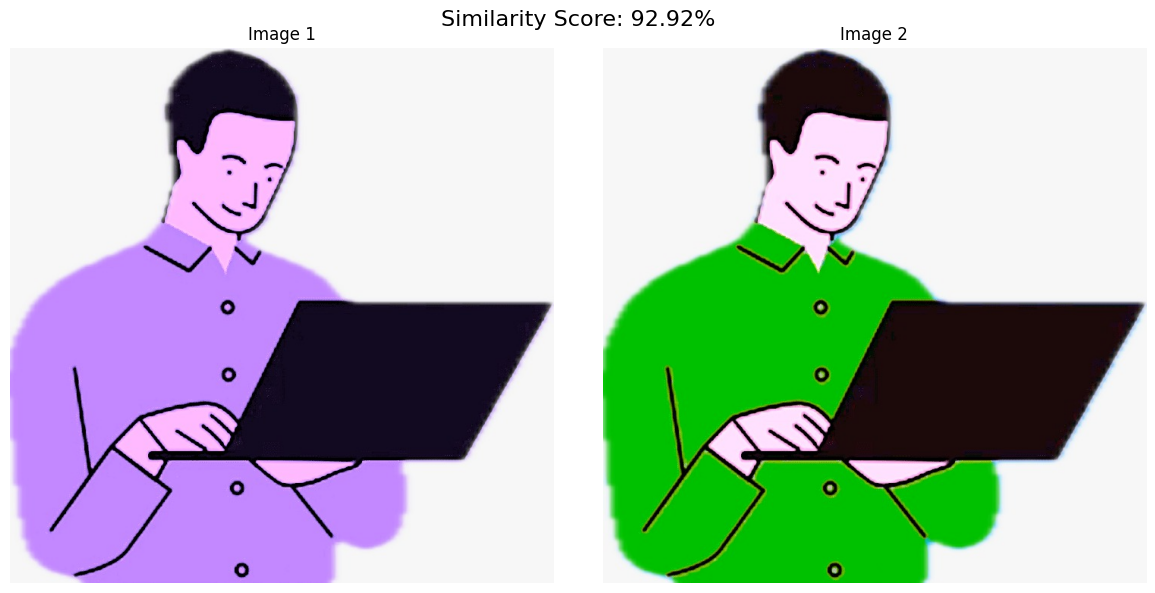

In [11]:
# As inception and Vgg16 provide best results
# we will take average of both to get score

input_img1 = "./testImages/person1.jpg"
input_img2 = "./testImages/person2.jpg"

display_images_with_similarity_scores(input_img1,input_img2)

#####----Building Dataframe for similar pairs----#####
processing  Khr01o.jpg
processing  Khr11o.jpg
processing  Khr31o.jpg
processing  Khr41o.jpg
processing  Khr51o.jpg
processing  ati11o.jpg
processing  ati21o.jpg
processing  ati31o.jpg
processing  dev11o.jpg
processing  dev21o.jpg
processing  dis11o.jpg
processing  dis21o.jpg
processing  dis31o.jpg
processing  dis41o.jpg
processing  dis81o.jpg
processing  disD1o.jpg
processing  jos11o.jpg
processing  jos31o.jpg
processing  jos81o.jpg
processing  jos91o.jpg
processing  khr21o.jpg
processing  sam11o.jpg
processing  sam21o.jpg
processing  sam31o.jpg
processing  sam41o.jpg
processing  sam51o.jpg
processing  sam61o.jpg
processing  sam71o.jpg
processing  sam81o.jpg
processing  sam91o.jpg
processing  samA1o.jpg
processing  sss91o.jpg
processing  sssG1o.jpg
processing  sssH1o.jpg
processing  sssI1o.jpg
processing  sssJ1o.jpg
processing  sssM1o.jpg
processing  sssN1o.jpg
processing  sssQ1o.jpg
processing  sssZ1o.jpg

#####----Building Datafr

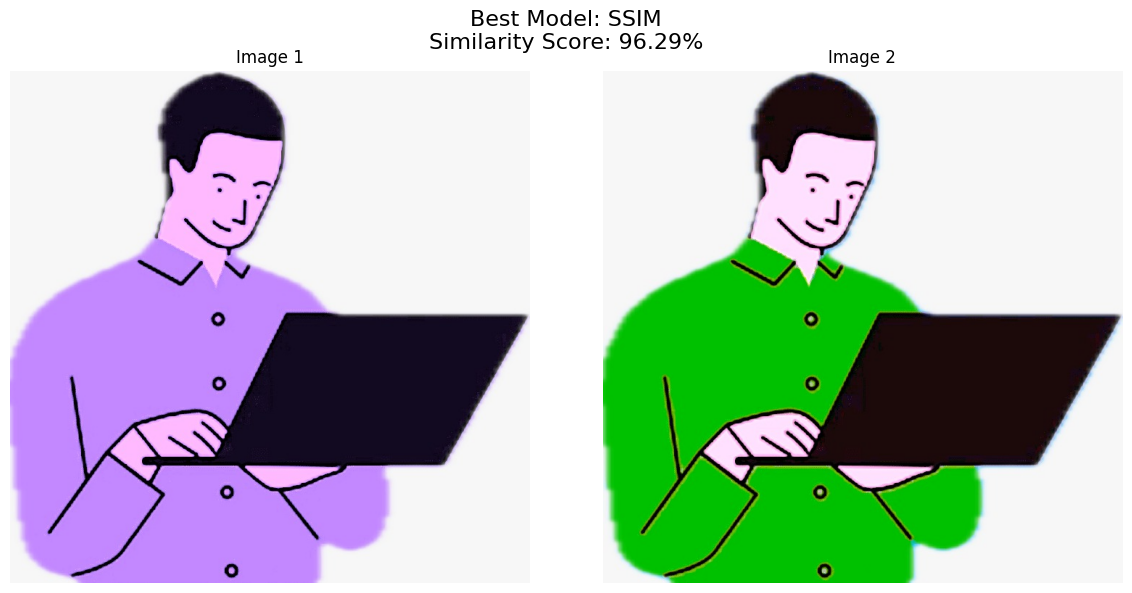

Best performing model: SSIM
Similarity Score: 96.29%


In [12]:
import cv2
import numpy as np
import os
import pandas as pd
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.preprocessing import image
import sklearn.metrics.pairwise as pairwise
cosine_similarity = pairwise.cosine_similarity
from matplotlib import pyplot as plt
import warnings
from skimage.metrics import structural_similarity as ssim

MODELS = ["vgg16", "resnet50", "inception", "mobilenet", "ssim"]

def load_and_preprocess_image(img_path, target_size, preprocess_func):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_func(img_array)

def calculate_similarity(img_path1, img_path2, model_name):
    models = {
        MODELS[0]: (VGG16, (224, 224), vgg_preprocess),
        MODELS[1]: (ResNet50, (224, 224), resnet_preprocess),
        MODELS[2]: (InceptionV3, (299, 299), inception_preprocess),
        MODELS[3]: (MobileNetV2, (224, 224), mobilenet_preprocess)
    }

    if model_name == "ssim":
        # Read images
        img1 = cv2.imread(img_path1)
        img2 = cv2.imread(img_path2)
        
        # Convert to grayscale
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        
        # Resize images to match
        gray1 = cv2.resize(gray1, (gray2.shape[1], gray2.shape[0]))
        
        # Calculate SSIM
        similarity_score, _ = ssim(gray1, gray2, full=True)
        return similarity_score * 100  # Convert to percentage

    if model_name not in models:
        raise ValueError(f"Unsupported model: {model_name}. Choose from {', '.join(models.keys())}")

    ModelClass, input_size, preprocess_func = models[model_name]

    #ignore warnings
    warnings.filterwarnings("ignore", category=UserWarning)
        
    # Load pre-trained model
    model = ModelClass(weights='imagenet', include_top=False, pooling='avg')

    # Load and preprocess images
    img1 = load_and_preprocess_image(img_path1, input_size, preprocess_func)
    img2 = load_and_preprocess_image(img_path2, input_size, preprocess_func)
    
    # Extract features
    features1 = model.predict(img1, verbose=0)
    features2 = model.predict(img2,verbose=0)
    
    # Calculate cosine similarity
    similarity = cosine_similarity(features1, features2)
    
    return similarity[0][0] * 100  # Convert to percentage

def display_images_with_similarity_scores(img_path1, img_path2):
    # Calculate similarity for all models
    scores = {}
    for model in MODELS:
        scores[model] = calculate_similarity(img_path1, img_path2, model)

    # Find the best performing model
    best_model = max(scores, key=scores.get)
    best_score = scores[best_model]
    
    # Load images using cv2
    img1 = cv2.imread(img_path1)
    img2 = cv2.imread(img_path2)
    
    # Convert BGR to RGB (cv2 loads in BGR, but matplotlib expects RGB)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display images
    ax1.imshow(img1)
    ax1.set_title('Image 1')
    ax1.axis('off')
    
    ax2.imshow(img2)
    ax2.set_title('Image 2')
    ax2.axis('off')
    
    # Add overall title with best model and its similarity score
    plt.suptitle(f'Best Model: {best_model.upper()}\nSimilarity Score: {best_score:.2f}%', fontsize=16)
    
    plt.tight_layout()
    plt.show()

    # Print the best model and its score
    print(f"Best performing model: {best_model.upper()}")
    print(f"Similarity Score: {best_score:.2f}%")

def getScore(img_path1,img_path2):
    results = {}

    for model in MODELS:
        similarity_score = calculate_similarity(img_path1, img_path2, model)
        results[model] = round(similarity_score,2)

    return results

def findBestModel(scores, type):
    bestVal = float('-inf' if type == "o" else "inf")
    bestModel = None
    if type == "o":
        for i in scores:
            if(scores[i] > bestVal):
                bestModel = i
                bestVal = scores[i]
    else:
        for i in scores:
            if(scores[i]<bestVal):
                bestModel = i
                bestVal = scores[i]
    return bestModel
        
def buildDataframe(testImagesFolder, type):
    index = 0
    if(type == "similar"):
        fileSuffix = 'o'
    elif(type == "nonsimilar"):
        fileSuffix = 'x'
    else:
        raise ValueError("Incorrect file type passed")

    df = pd.DataFrame(columns=["images"] + MODELS + ["best"])
    for filename in sorted(os.listdir(testImagesfolder)):
        f = os.path.join(testImagesfolder, filename)
        # checking if it is a file
        if os.path.isfile(f):
            try:
                if(filename[4] == '1' and filename[5] == fileSuffix):
                    print("processing ", filename)
                    file1 = f
                    filename2 = filename[:4] + '2' + filename[5:]
                    file2 = os.path.join(testImagesfolder, filename2)
                    #plotImages(file1,file2)
                    scores = getScore(file1,file2)
                    bestModel = findBestModel(scores, fileSuffix)
                    df.loc[index] = [filename[3:6]+" "+ filename2[3:6]] + [scores[model] for model in MODELS] + [bestModel]
                    index += 1
            except:
                print("not able to find other file for", filename)
    return df

testImagesfolder = "./testImages/"
print("#####----Building Dataframe for similar pairs----#####")
SimilarDataframe = buildDataframe(testImagesfolder, "similar")
print()
print("#####----Building Dataframe for non similar pairs----#####")
nonSimilarDataframe = buildDataframe(testImagesfolder,"nonsimilar")
print("Processing Complete")

bestModelSimilar = SimilarDataframe.best.mode()[0]
bestModelSimilarFreq = SimilarDataframe['best'].value_counts()[bestModelSimilar]

bestModelNonSimilar = nonSimilarDataframe.best.mode()[0]
bestModelNonSimilarFreq = nonSimilarDataframe['best'].value_counts()[bestModelNonSimilar]

print("Similar: " + str(bestModelSimilar) + " " + str(bestModelSimilarFreq) + "/" + str(SimilarDataframe.shape[0]))
print("Non Similar: " + str(bestModelNonSimilar) + " " + str(bestModelNonSimilarFreq) + "/" + str(nonSimilarDataframe.shape[0]))

# Test with your input images
input_img1 = "./testImages/person1.jpg"
input_img2 = "./testImages/person2.jpg"

display_images_with_similarity_scores(input_img1, input_img2)

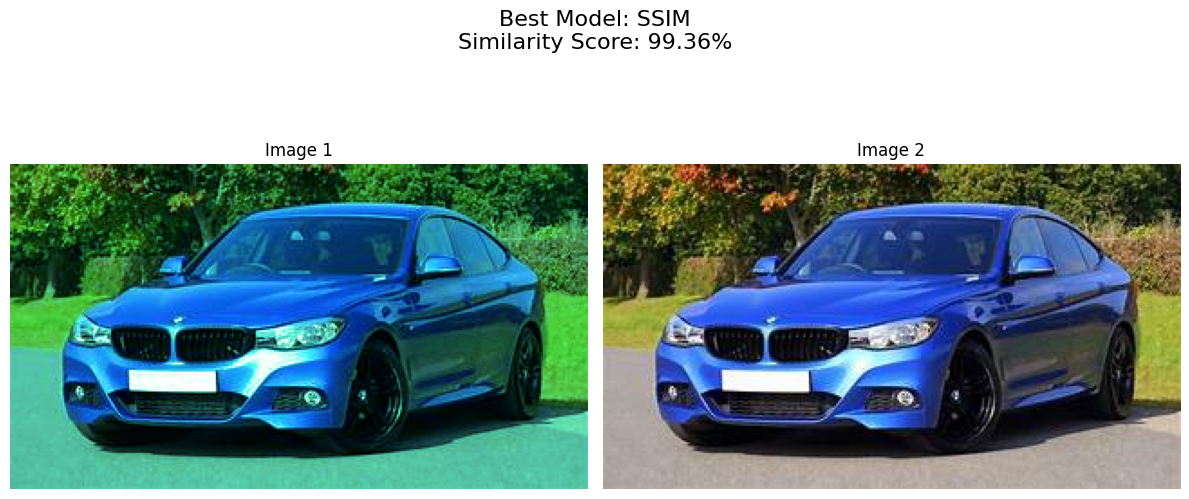

Best performing model: SSIM
Similarity Score: 99.36%


In [13]:
input_img1 = "./testImages/sameer1.jpg"
input_img2 = "./testImages/sameer2.jpg"

display_images_with_similarity_scores(input_img1,input_img2)

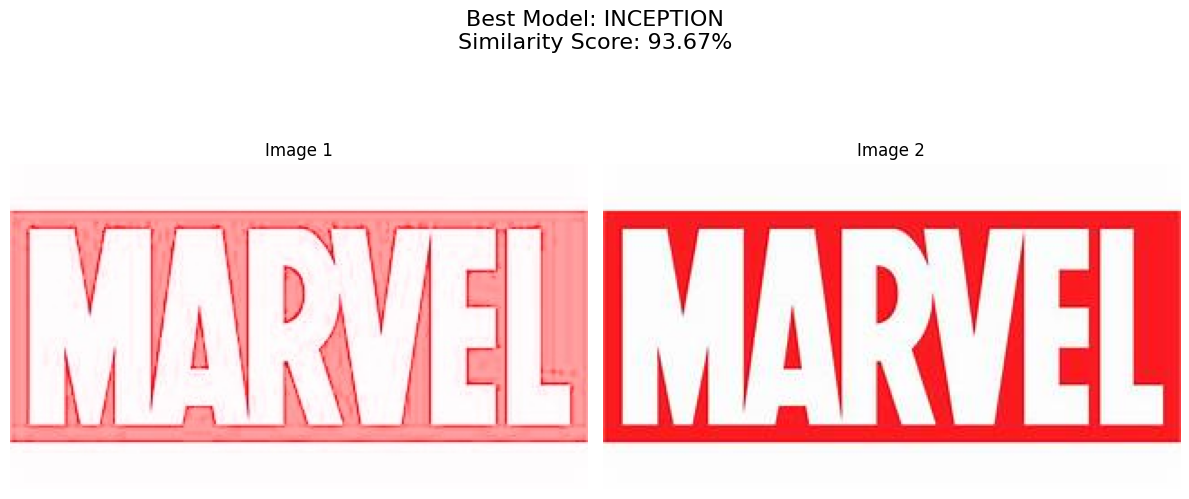

Best performing model: INCEPTION
Similarity Score: 93.67%


In [14]:
input_img1 = "./testImages/mav1.jpg"
input_img2 = "./testImages/mav2.jpg"

display_images_with_similarity_scores(input_img1,input_img2)

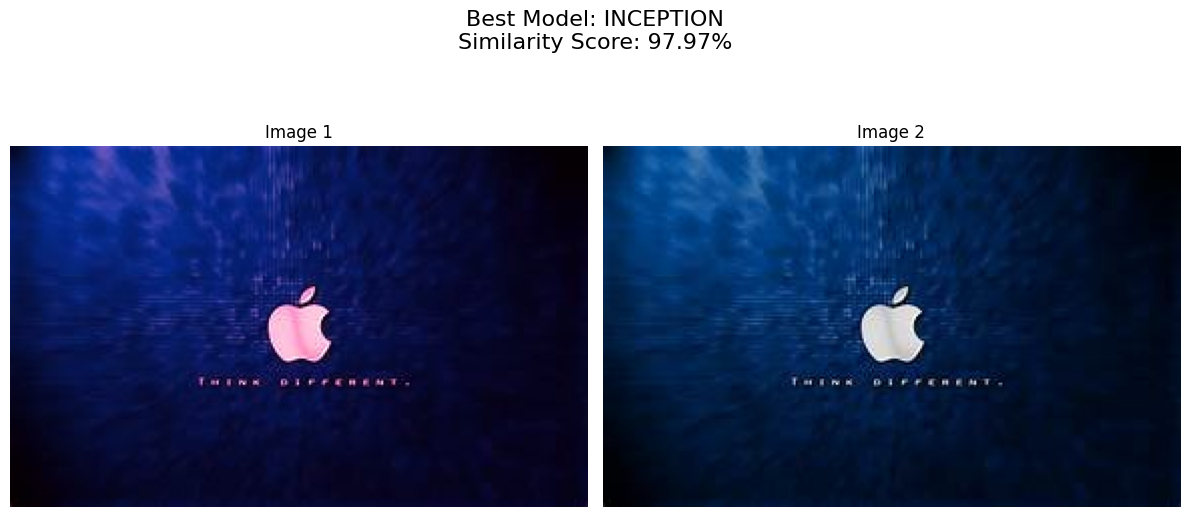

Best performing model: INCEPTION
Similarity Score: 97.97%


In [15]:
input_img1 = "./testImages/app1.jpg"
input_img2 = "./testImages/app2.jpg"

display_images_with_similarity_scores(input_img1,input_img2)